In [1]:
import sys
sys.path.append("../../")

import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ml_collections import ConfigDict


from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge

2024-01-31 13:21:19.492071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 13:21:19.492106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 13:21:19.492999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 13:21:21.021976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

## Unconditional process

In [96]:
def sample_ellipse(n_pts, scale, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0):
    theta = jnp.linspace(0, 2 * jnp.pi, n_pts, endpoint=False)
    x = a * jnp.cos(theta)
    y = b * jnp.sin(theta)
    return scale * jnp.stack([x, y], axis=1) + shifts[None, :]

def reconstruct_trajectories(diff_coeffs_flatten_traj, initial_shape):
    diff_coeffs_traj = jnp.stack(
        jnp.split(diff_coeffs_flatten_traj, 2, axis=-1),
        axis=-1
    )
    n_pts = initial_shape.shape[-2]
    n_bases = diff_coeffs_traj.shape[-2]
    n_padding = (n_pts - n_bases) // 2
    diff_coeffs_traj_padded = jnp.pad(
        diff_coeffs_traj,
        ((0, 0), (0, 0), (n_padding, n_padding), (0, 0)),
        mode='constant',
        constant_values=0
    )
    diff_coeffs_traj_padded = jnp.fft.ifftshift(diff_coeffs_traj_padded, axes=-2)
    diff_traj_recon = jnp.fft.ifft(diff_coeffs_traj_padded, n=n_pts, axis=-2, norm='backward').real
    traj = diff_traj_recon + initial_shape[None, None, :, :]
    return traj

def plot_trajectories(traj, sample_idx, ax, cmap_name='viridis'):
    cmap = colormaps.get_cmap(cmap_name)
    colors = cmap(jnp.linspace(0, 1, traj.shape[-2]))
    for i in range(traj.shape[-2]):
        ax.scatter(traj[sample_idx, 0, i, 0], traj[sample_idx, 0, i, 1], color=colors[i], s=20, marker='o')
        ax.scatter(traj[sample_idx, -10, i, 0], traj[sample_idx, -10, i, 1], color=colors[i], s=20, marker='x')
        ax.plot(traj[sample_idx, :, i, 0], traj[sample_idx, :, i, 1], color=colors[i], alpha=0.3)
    return ax

def hidden_axes(fig, ax):
    fig.add_subplot(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    return ax

In [110]:
n_bases = 16
n_pts = 128
initial_shape = sample_ellipse(n_pts, 0.5)
initial_shape_ = sample_ellipse(2*n_pts, 0.5)
print(initial_shape.shape)

sde_config = ConfigDict(
    {
        'init_S': initial_shape,
        'n_bases': n_bases,
        'n_grid': n_bases,
        'grid_range': [-1.0, 1.0],
        'alpha': 1.0,
        'sigma': 0.2,
        'T': 1.0,
        'N': 50,
        'dim': 2
    }
)

unconditional_trajs = []
for n_bases in [8, 16, 24]:
    sde_config['n_bases'] = n_bases
    sde_config['n_grid'] = n_bases
    sde = FourierGaussianKernelSDE(sde_config)
    bridge = DiffusionBridge(sde)
    initial_diff_coeffs = jnp.zeros((n_bases, 2), dtype=jnp.complex64)
    initial_diff_flatten = jnp.concatenate(
        [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
        axis=0
    )
    forward_unconditional = bridge.simulate_forward_process(
        initial_val = initial_diff_flatten,
        num_batches = 1
    )
    forward_unconditional_diff_coeffs = forward_unconditional["trajectories"]
    forward_unconditional_traj = reconstruct_trajectories(
        forward_unconditional_diff_coeffs,
        initial_shape_,
    )
    unconditional_trajs.append(forward_unconditional_traj)

(128, 2)


Text(0.5, 0.98, 'Unconditional Forward Trajectories ($\\sigma=0.2$)')

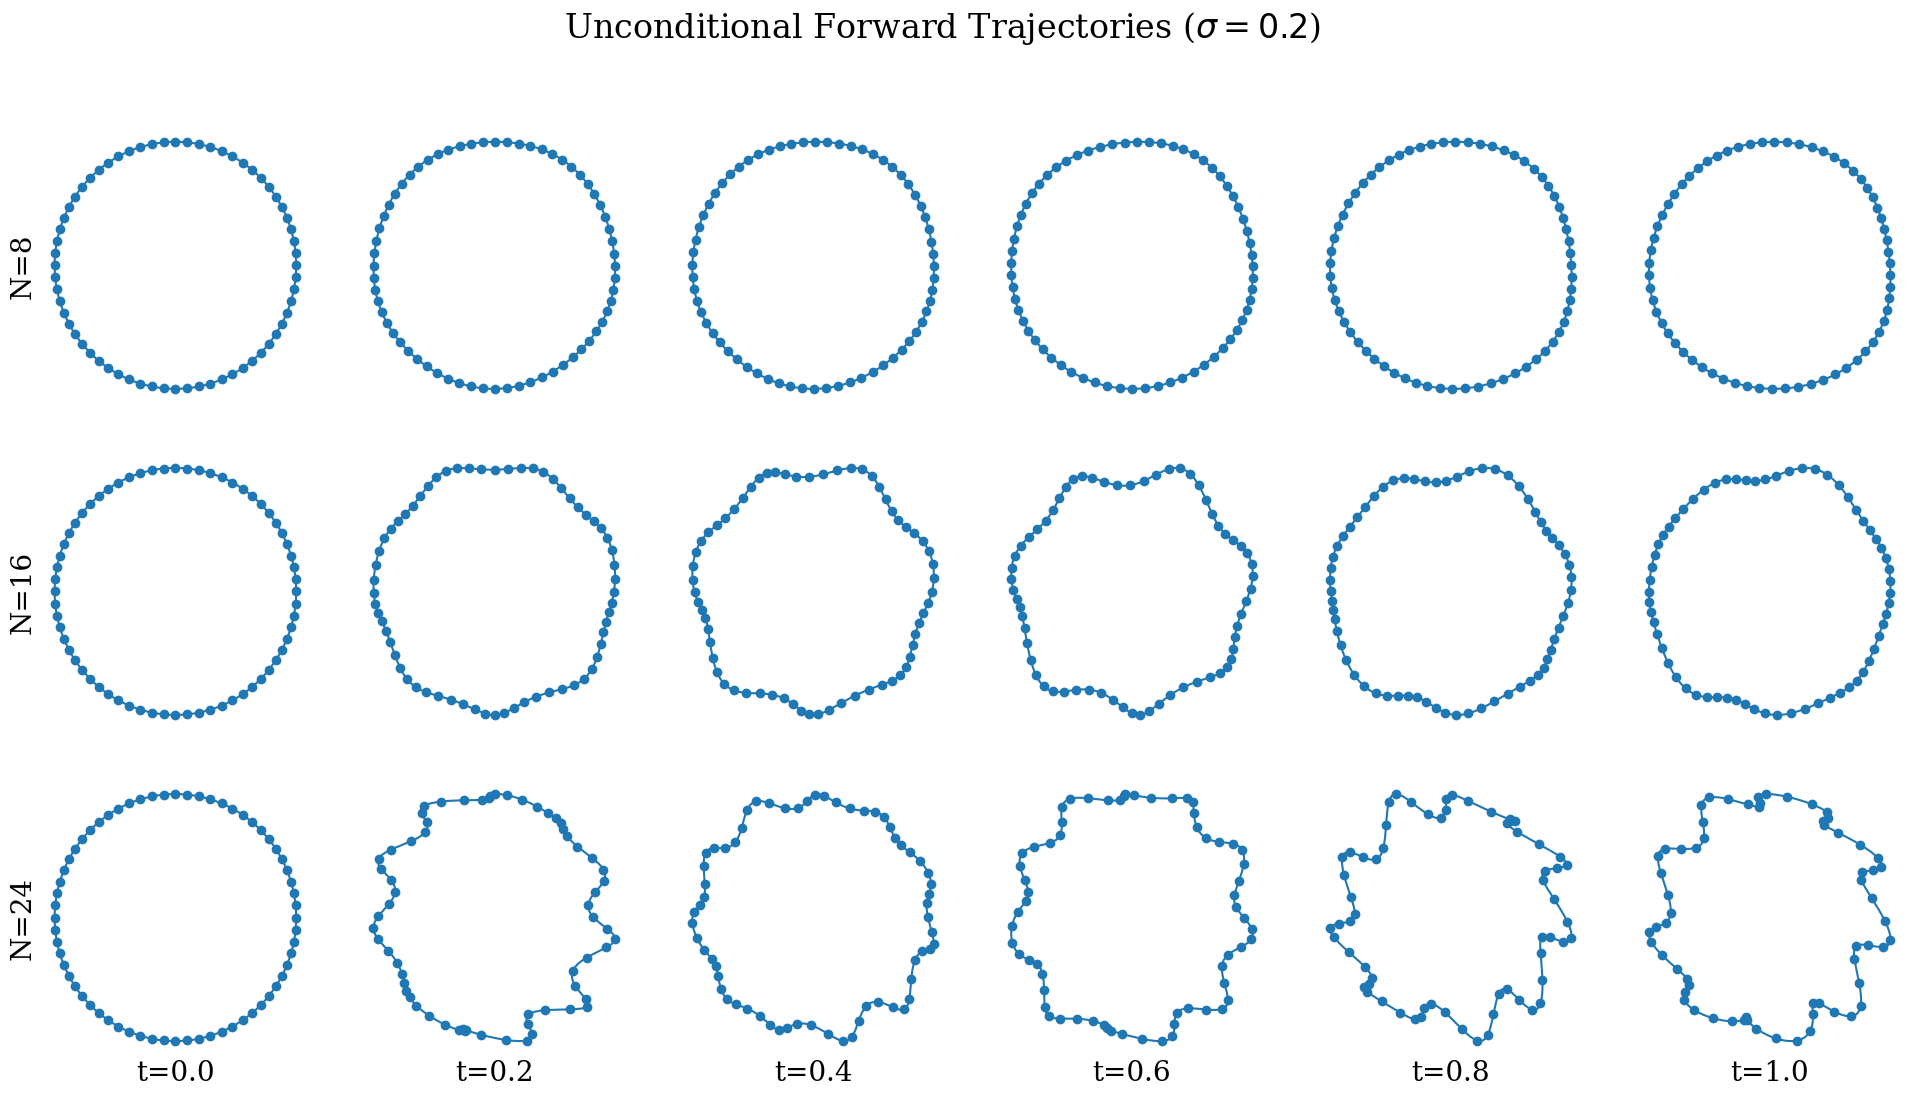

In [111]:
fig, ax = plt.subplots(3, 6, figsize=(24, 12))
for i in range(3):
    ax[i, 0].plot(unconditional_trajs[i][0, 0, :, 0], unconditional_trajs[i][0, 0, :, 1])
    ax[i, 0].scatter(unconditional_trajs[i][0, 0, ::4, 0], unconditional_trajs[i][0, 0, ::4, 1])
    hidden_axes(fig, ax[i, 0])
    for j in range(1, 6):
        ax[i, j].plot(unconditional_trajs[i][0, 10*j-1, :, 0], unconditional_trajs[i][0, 10*j-1, :, 1])
        ax[i, j].scatter(unconditional_trajs[i][0, 10*j-1, ::4, 0], unconditional_trajs[i][0, 10*j-1, ::4, 1])
        hidden_axes(fig, ax[i, j])
for i in range(6):
    ax[2, i].set_xlabel(fr"t={i*0.2:.1f}", fontsize=20, fontfamily='serif')

for j in range(3):
    ax[j, 0].set_ylabel(fr"N={j*8+8}", fontsize=20, fontfamily='serif')

fig.suptitle(
    r"Unconditional Forward Trajectories ($\sigma=0.2$)",
    fontsize=24,
    fontfamily='serif'
)

In [112]:
fig.savefig("../figures/unconditional_trajs_different_n_bases.png", dpi=100, bbox_inches='tight')

In [113]:
unconditional_trajs = []
sde_config['n_bases'] = 16
sde_config['n_grid'] = 16
initial_diff_coeffs = jnp.zeros((16, 2), dtype=jnp.complex64)
initial_diff_flatten = jnp.concatenate(
    [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
    axis=0
)
for sigma in [0.1, 0.2, 0.3]:
    sde_config['sigma'] = sigma
    sde = FourierGaussianKernelSDE(sde_config)
    bridge = DiffusionBridge(sde)

    forward_unconditional = bridge.simulate_forward_process(
        initial_val = initial_diff_flatten,
        num_batches = 1
    )
    forward_unconditional_diff_coeffs = forward_unconditional["trajectories"]
    forward_unconditional_traj = reconstruct_trajectories(
        forward_unconditional_diff_coeffs,
        initial_shape_,
    )
    unconditional_trajs.append(forward_unconditional_traj)

Text(0.5, 0.98, 'Unconditional Forward Trajectories ($N=16$)')

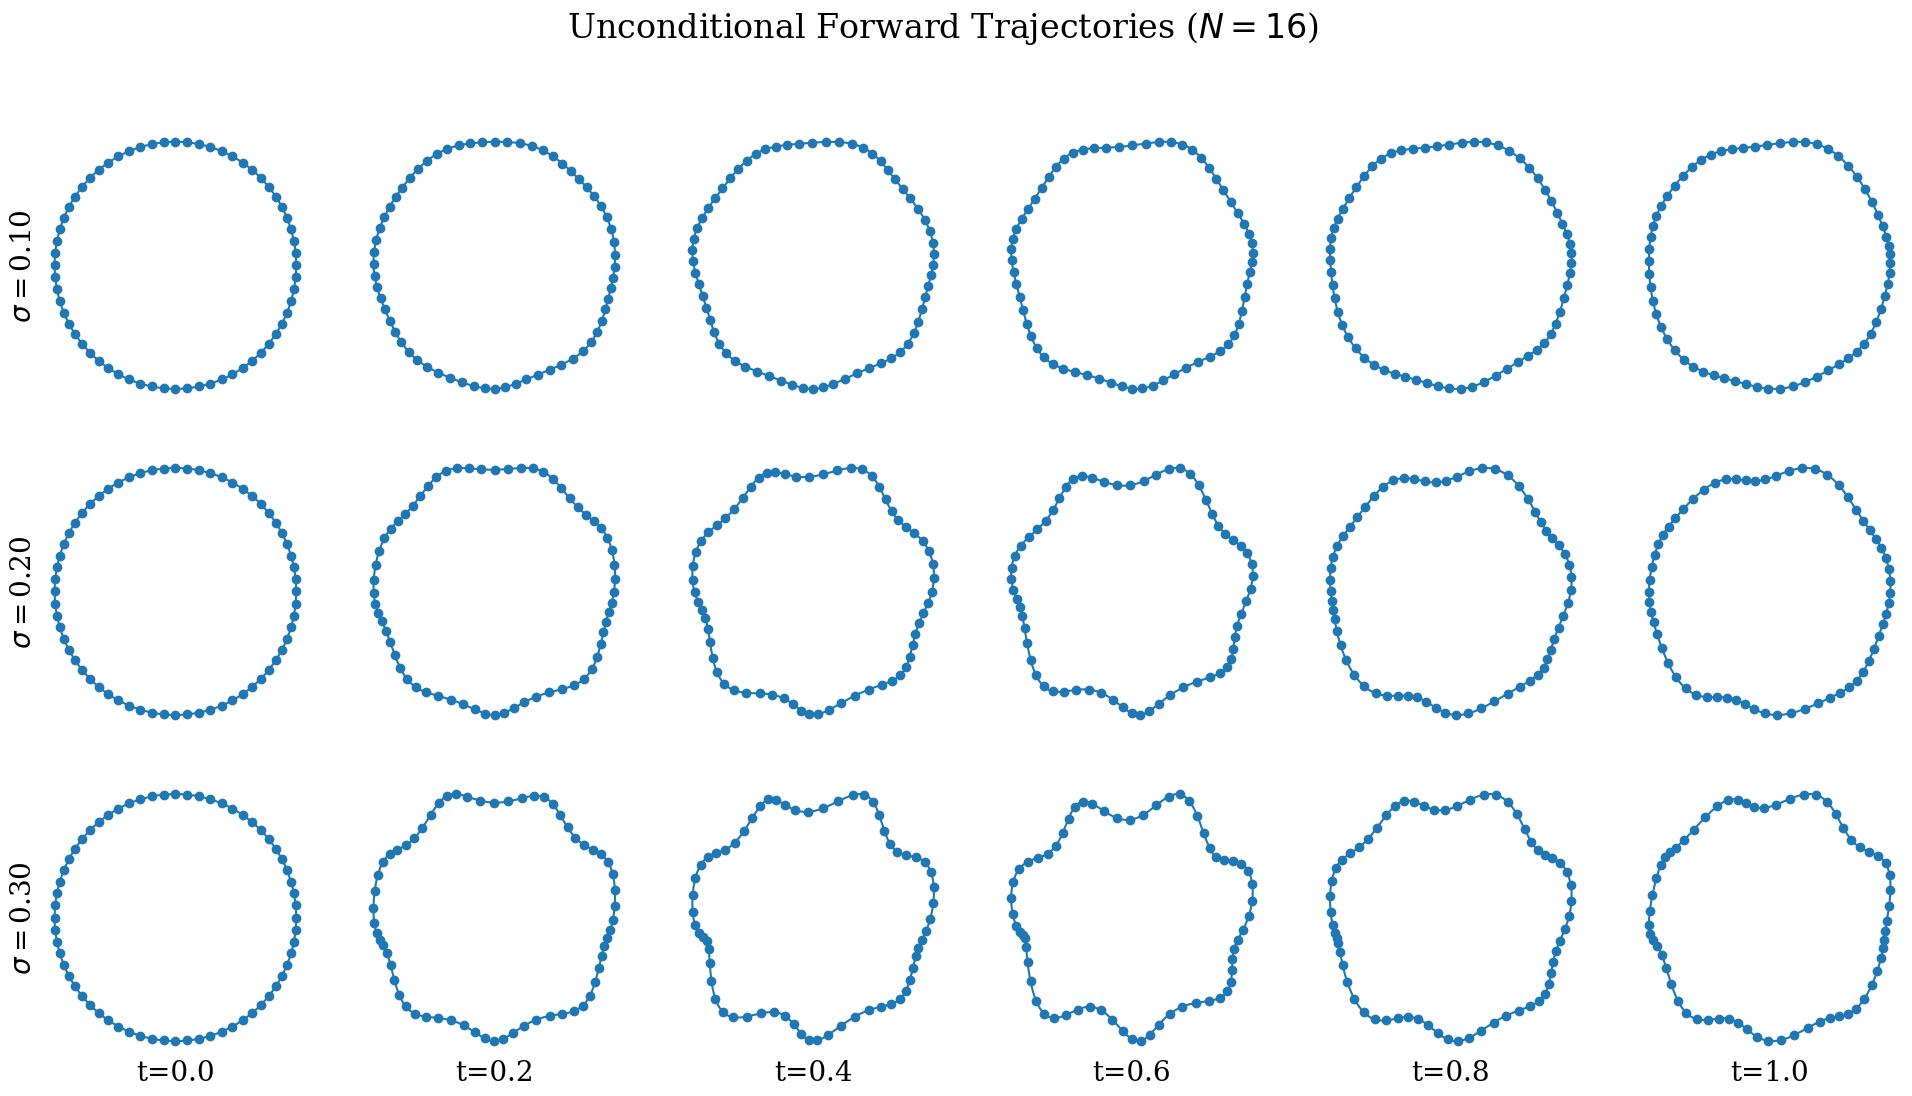

In [114]:
fig, ax = plt.subplots(3, 6, figsize=(24, 12))
for i in range(3):
    ax[i, 0].plot(unconditional_trajs[i][0, 0, :, 0], unconditional_trajs[i][0, 0, :, 1])
    ax[i, 0].scatter(unconditional_trajs[i][0, 0, ::4, 0], unconditional_trajs[i][0, 0, ::4, 1])
    hidden_axes(fig, ax[i, 0])
    for j in range(1, 6):
        ax[i, j].plot(unconditional_trajs[i][0, 10*j-1, :, 0], unconditional_trajs[i][0, 10*j-1, :, 1])
        ax[i, j].scatter(unconditional_trajs[i][0, 10*j-1, ::4, 0], unconditional_trajs[i][0, 10*j-1, ::4, 1])
        hidden_axes(fig, ax[i, j])
for i in range(6):
    ax[2, i].set_xlabel(fr"t={i*0.2:.1f}", fontsize=20, fontfamily='serif')

for j in range(3):
    ax[j, 0].set_ylabel(fr"$\sigma=${j*0.1+0.1:.2f}", fontsize=20, fontfamily='serif')

fig.suptitle(
    r"Unconditional Forward Trajectories ($N=16$)",
    fontsize=24,
    fontfamily='serif'
)

In [115]:
fig.savefig("../figures/unconditional_trajs_different_sigma.png", dpi=100, bbox_inches='tight')

### Covariance matrices

In [ ]:
def landmark_covariance(lmks, alpha, sigma):
    diff = lmks[:, jnp.newaxis, :] - lmks[jnp.newaxis, :, :]
    dis = jnp.sum(jnp.square(diff), axis=-1)
    kernel = alpha * jnp.exp(-dis / sigma**2)
    return jnp.matmul(kernel, kernel)

def coefficient_covariance(coeffs, init_shape, alpha, sigma):
    n_pts = init_shape.shape[0]
    n_bases = coeffs.shape[0]
    n_padding = (n_pts - n_bases) // 2
    def eval_coeffs(coeffs):
        coeffs = coeffs / jnp.sqrt(n_pts)
        coeffs = jnp.pad(coeffs, ())

